# 1-D Trajectory Matrix Completion with Velocity Constraint

In this notebook, we will run a 1D algorithm similar to LADMAP to impute 2 matrices that misses data at random position: one is the matrix of position, while the other is the matrix of velocity.

Then, if it is possible, we try to compare the performance, between imputing two matrices independently, and with other commonly used methods.

Candidates for comparison:
<ol>
<li>SciPy's interpolation methods: include Spline fitting</li>
<li>Fourier/Wavelet smoothing</li>
</ol>

In [2]:
import numpy as np
np.random.seed(6969)
from matplotlib import pyplot as plt

from scipy.stats import expon, norm
%load_ext autoreload
%autoreload 2

In [3]:
def plot_expon_pdf(loc, scale):
    x = np.linspace(expon.ppf(0.01, loc=loc, scale=scale), expon.ppf(0.99, loc=loc, scale=scale), 100)
    plt.plot(x, expon.pdf(x, loc=loc, scale=scale), label='expon pdf')

In [4]:
def sample_expon(loc, scale):
    return expon.rvs(loc=loc, scale=scale, size=1).item()

In [5]:
def sample_norm(mean, sd):
    return norm.rvs(loc=mean, scale=sd, size=1).item()

Generate the trajectory matrix and the velocity matrix: we generate the velocity matrix first, then integrate the velocity to get the position:

In [6]:
num_of_traces = 200
length_of_traces = 250
rise_period_scale = 0.1 * length_of_traces
transition_period_scale = 0.2*length_of_traces

v_mat = np.zeros((num_of_traces, length_of_traces))

for trace in range(num_of_traces):
    t = 0 # time index
    p = 0 # period index
    while t < length_of_traces:
        if p == 0:
            period_length = int(sample_expon(loc=0, scale=rise_period_scale))
            while period_length < 5:
                period_length = int(sample_expon(loc=0, scale=rise_period_scale))
        else:
            period_length = int(sample_expon(loc=0, scale=transition_period_scale))

        if t + period_length < length_of_traces:
            if p == 0: # this is a rise period 
                rise_to_value = sample_norm(mean=15, sd=1)
                if period_length == 1:
                    mt = np.arange(period_length) * rise_to_value
                else:
                    mt = np.arange(period_length) / (period_length - 1) * rise_to_value
                v_mat[trace,:period_length] = mt
            else: # this is a transition period
                hold_value = sample_norm(mean=15, sd=2)
                mt = np.ones((period_length,)) * hold_value
                v_mat[trace,t:t+period_length] = mt
            p+=1
            t = t + period_length
        else:
            # this is a fall period
            period_length = length_of_traces - t
            if period_length == 1:
                mt = v_mat[trace,t-1] - np.arange(period_length) * v_mat[trace,t-1]
            else:
                mt = v_mat[trace,t-1] - np.arange(period_length) / (period_length - 1) * v_mat[trace,t-1]
            v_mat[trace,t:t+period_length] = mt
            v_mat[trace,t:t+period_length] = mt
            t = length_of_traces + 1 # ensure breaking the loop

The velocity traces:

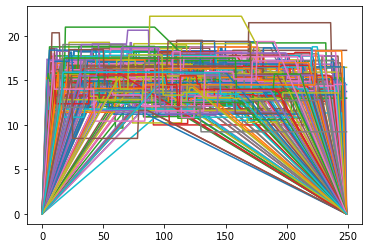

In [7]:
for i in range(num_of_traces):
    plt.plot(v_mat[i,:])

The position matrix is just row-wise integration of the velocity traces. Each velocity trace corresponds to one row of $v_{mat}$:

In [8]:
x_mat = np.cumsum(v_mat, axis=1)

To make it much more challenging, we are going to devide the x_mat into 3 clusters, corresponding to different initial position $x_0$:

In [9]:
trace_cluster_assignment = np.zeros((num_of_traces,))
trace_cluster_assignment = np.random.choice(3, num_of_traces)
print('Cluster assignment of each trace: ', trace_cluster_assignment)

Cluster assignment of each trace:  [0 2 1 0 1 2 1 0 0 1 1 0 2 1 2 0 1 1 0 2 0 1 1 0 2 0 0 2 0 1 2 0 0 0 2 0 2
 0 0 1 2 2 1 1 1 1 0 0 2 0 2 0 0 2 1 0 2 1 2 2 2 1 1 1 0 0 0 1 0 0 2 2 2 1
 2 1 2 0 0 0 2 2 1 2 1 1 2 0 2 0 0 0 2 1 0 1 2 2 2 2 0 1 0 0 0 0 0 2 0 2 1
 0 2 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 2 0 2 0 2 0 1 1 2 2 0 2 1 2 2 1 0 0
 1 1 1 1 2 0 0 1 1 2 2 0 2 2 2 0 1 1 1 2 1 2 0 0 1 1 0 1 0 0 0 2 2 1 1 2 0
 0 1 2 2 0 2 1 0 1 0 1 0 1 0 1]


In [10]:
trace_x0 = np.copy(trace_cluster_assignment)
# Let there be some noise in x0
epsilon_vector = norm.rvs(loc=0, scale=0.5, size=num_of_traces)
trace_x0[trace_x0==0] = -1000
trace_x0[trace_x0==2] = 1000
trace_x0 = trace_x0 + epsilon_vector
# Adjust the starting position
x_mat = x_mat + np.tile(trace_x0, (length_of_traces, 1)).T

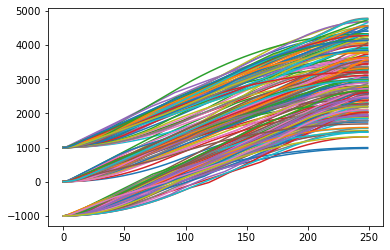

In [11]:
for i in range(num_of_traces):
    plt.plot(x_mat[i,:])

We define the differential operator $D$ that "derives" $x$ to get $v$:

In [12]:
D = -np.eye(x_mat.shape[1])
for i in range(x_mat.shape[1]-1):
    D[i+1,i] = 1
# D = np.concatenate([np.zeros((D.shape[0],)),D])

And we also reassign this derivative to v_mat (so the original v_mat is gone)

In [13]:
v_mat = x_mat @ D

(0.0, 25.0)

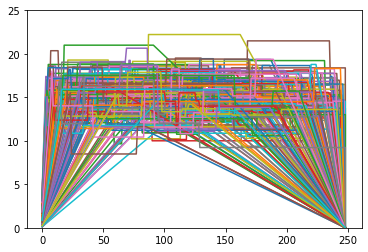

In [14]:
for i in range(v_mat.shape[0]):
    plt.plot(v_mat[i,:])
plt.ylim((0,25))

Now we are going to mask several elements of the matrices $V$ and $X$, which simulate information corruption due to CAM/ADS-B packet loss/corruption. The goal is to impute these entries.

In what follows, we use Bernoulli distribution for the masking of values. One may consider other distributions, such as Gaussian. The mask indices are distributed independently across examples, and we also assume independence between $X$ and $V$.

In ADS-B data, the $X$ matrix is usually masked a lot more than $V$. The independence hypothesis seems to match up with ADS-B system design, if the aircraft is well within coverage. But mask indices due to lack of coverage may create correlation between examples, entries, and even between $X$ and $V$. We will NOT deal with this in this simple notebook example:

In [15]:
v_mat_nan = np.zeros_like(v_mat)
x_mat_nan = np.zeros_like(x_mat)
for trace in range(num_of_traces):
    row_index_of_mask = np.random.uniform(high=3, size=(length_of_traces-1,)) # 1/3 missing
    row = v_mat[trace,:-1].copy()
    row[row_index_of_mask < 1] = np.nan
    v_mat_nan[trace,:-1] = row

    row_index_of_mask = np.random.uniform(high=4/3, size=(length_of_traces,)) # 3/4 missing
    row = x_mat[trace,:].copy()
    row[row_index_of_mask < 1] = np.nan
    x_mat_nan[trace,:] = row    

In [16]:
from numpy import ma
v_mat_maskarray = ma.masked_invalid(v_mat_nan)
x_mat_maskarray = ma.masked_invalid(x_mat_nan)

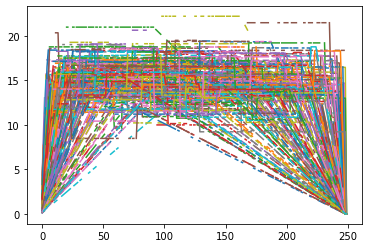

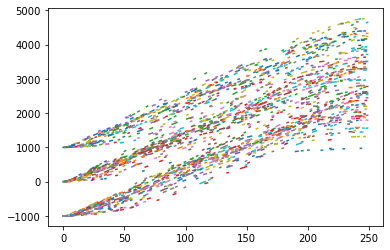

In [17]:
for i in range(num_of_traces):
    plt.plot(v_mat_maskarray[i,:])

plt.figure()
for i in range(num_of_traces):
    plt.plot(x_mat_maskarray[i,:])

Now let's try to recover the two original matrices:

First we turn all "missing values" to zero. This turns a masked matrix to a conventional matrix, but the missing data is still there. The algorithm knows which entry is missing through the "mask index", which is a matrix of the same size, whose each entry is 1 if available, and 0 if unavailable.

In [18]:
v_mat_masked_to_zero = np.nan_to_num(v_mat_nan)
x_mat_masked_to_zero = np.nan_to_num(x_mat_nan)
# This matrix has all NaNs replaced by zeros

In [19]:
v_mask = ma.getmask(v_mat_maskarray).astype(int)
x_mask = ma.getmask(x_mat_maskarray).astype(int)
# This matrix denotes 1 at positions that previously were NaNs but were replaced with zeros, otherwise it is zero

# LADMAP for Dual Matrices Completion

In [20]:
from svt import SVT, get_spectrum

In [45]:
from tqdm.notebook import tqdm
from scipy.linalg import svd 

In [46]:
def nuclear_norm(X):
    _, s, __ = svd(X)
    return(np.sum(s))

In [47]:
def frobenius_dot(X,Y):
    return(np.sum(X*Y))

In [51]:
def frobenius_norm_squared(X):
    return(np.sum(X*X))

In [52]:
def objective_fn(X, V, D, Xm, Vm, m1, m2, m3, mu):
    return(nuclear_norm(X) + nuclear_norm(V) + frobenius_dot(m1, X-Xm) + frobenius_dot(m2, V-Vm) + frobenius_dot(m3, X@D - V) + mu/2 * (frobenius_norm_squared(X-Xm) + frobenius_norm_squared(V-Vm) + frobenius_norm_squared(X@D - V)))

In [53]:
# Hyper-parameters
rho = 1.9 # mu dynamic scaling ratio
mu0 = 200e-5 # 200-250: size of the matrix to be filled
mu_max = 1e-1
indices_test = np.random.choice(num_of_traces, 3)

# Initial variables
x_hat = np.zeros_like(x_mat) # primal
#x_hat = np.copy(x_mat_masked_to_zero)
#v_hat = np.copy(v_mat_masked_to_zero)
v_hat = np.zeros_like(v_mat) # primal
m1 = np.zeros_like(x_mat) # dual 
m2 = np.zeros_like(v_mat) # dual
m3 = np.zeros_like(v_mat) # dual

mu = mu0
tau = 1/(1.02 * 200)

In [25]:
max_iter = int(1e3)
obj_log = np.zeros((max_iter,))

for iter in tqdm(range(max_iter)):
    # Update V_hat
    # SVT by formula on page 3
    v_hat = SVT(v_mat_masked_to_zero, 1./mu0)

    # Update X_hat 
    # The subgradient
    xg = 2*(x_hat @ D - v_hat + m3 * 1./mu)@D.T
    # SVT by formula on page 4
    x_hat = SVT((x_mat_masked_to_zero - m1 * 1./mu + 1./tau * (x_hat - tau/2 * xg))/(1+1/tau), 1/(mu * (1+1/tau)))
    
    # Update the Lagrange multipliers
    m1 = m1 + mu * (x_hat - x_mat_masked_to_zero)
    m2 = m2 + mu * (v_hat - v_mat_masked_to_zero)
    m3 = m3 + mu * (x_hat @ D - v_hat)

    obj_log[iter] = objective_fn(x_hat, v_hat, D, x_mat_masked_to_zero, v_mat_masked_to_zero, )

    # Update the penalty
    # mu = min(rho * mu, mu_max)


  0%|          | 0/1000 [00:00<?, ?it/s]

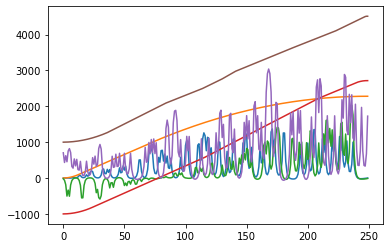

In [26]:
for i in indices_test:
    plt.plot(x_hat[i,:])
    plt.plot(x_mat[i,:])

In [25]:
from scipy.linalg import svd 
u, s, vh = svd(x_mat)

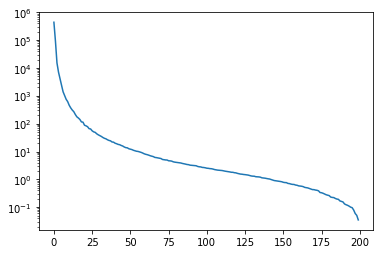

In [32]:
plt.figure()
ax = plt.subplot()
ax.plot(s)
ax.set_yscale('log')

(1.0, 35.0)

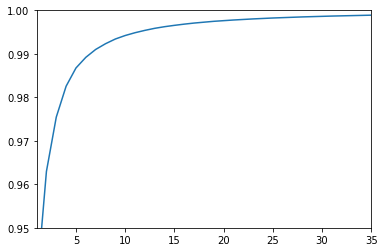

In [44]:
m = np.sum(s)
n = np.cumsum(s)
plt.plot(n/m)
plt.ylim((.95,1))
plt.xlim((1,35))